Epoch 1, Loss: 159.4143
Epoch 2, Loss: 113.9189
Epoch 3, Loss: 108.8806
Epoch 4, Loss: 107.0803
Epoch 5, Loss: 105.9471
Epoch 6, Loss: 105.1975
Epoch 7, Loss: 104.5834
Epoch 8, Loss: 104.0448
Epoch 9, Loss: 103.5625
Epoch 10, Loss: 103.2033


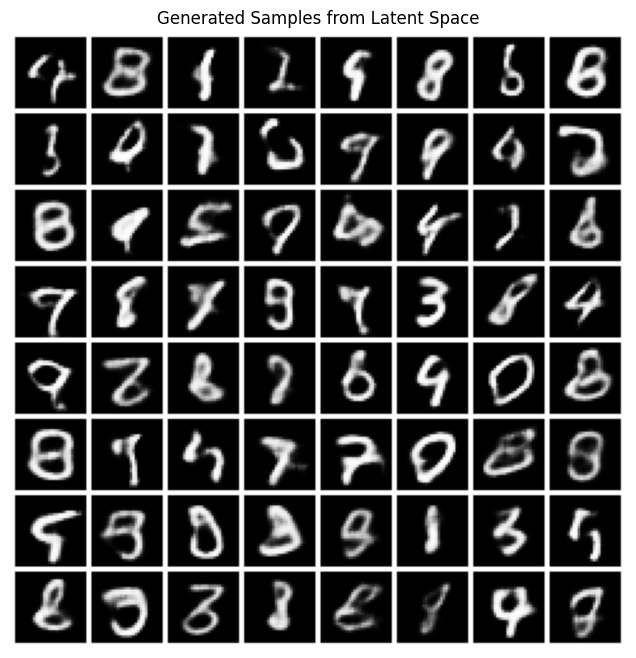

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset
mnist_path = './data'
train_dataset = datasets.MNIST(root=mnist_path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=mnist_path, train=False, download=True, transform=transform)
full_dataset = ConcatDataset([train_dataset, test_dataset])

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        self.fc1 = nn.Conv2d(64, latent_dim, kernel_size=1)
        self.fc2 = nn.Conv2d(64, latent_dim, kernel_size=1)
        self.fc3 = nn.ConvTranspose2d(latent_dim, 64, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc1(x).squeeze()
        logvar = self.fc2(x).squeeze()
        return mu, logvar

    def decode(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1)
        x = self.fc3(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training Function
def train_vae(model, dataset, config):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    data_loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    for epoch in range(config['num_epochs']):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(data_loader.dataset):.4f}')
    
    # Save model
    os.makedirs(os.path.dirname(config['save_path']), exist_ok=True)
    torch.save(model.state_dict(), config['save_path'])

# Sampling Function
def sample_from_vae(model, latent_dim, num_samples=64):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()
        grid = torchvision.utils.make_grid(samples, nrow=8, pad_value=1)
        plt.figure(figsize=(8, 8))
        plt.title("Generated Samples from Latent Space")
        plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

# Config
config = {
    'lr': 5e-4,
    'num_epochs': 10,
    'batch_size': 32,
    'save_path': 'models/vae_mnist.pth'
}

# Run Training
model = VAE(latent_dim=16)
train_vae(model, full_dataset, config)

# Load model & Sample
model.load_state_dict(torch.load(config['save_path'], map_location=device))
model.to(device)
sample_from_vae(model, latent_dim=16)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# ----------------------------------------
#   VAE2: Residual Super-Resolution VAE
# ----------------------------------------
class VAE2(nn.Module):
    def __init__(self, latent_dim=16, patch_size=7):
        super().__init__()
        self.latent_dim = latent_dim
        self.patch_size = patch_size
        self.num_patches = (28 // patch_size) ** 2

        # Encoder: full image → latent parameters μ₂, logσ₂²
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # → 16×28×28
            nn.ReLU(),
            nn.MaxPool2d(2),                              # → 16×14×14
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # → 32×14×14
            nn.ReLU(),
            nn.MaxPool2d(2),                              # → 32× 7×7
            nn.Conv2d(32, 64, kernel_size=7)              # → 64× 1×1
        )
        self.fc_mu     = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Optional positional embedding for patch index
        self.pos_emb = nn.Embedding(self.num_patches, latent_dim)

        # Decoder: (z₂ + pos_emb + flattened patch) → 7×7 residual patch
        in_dim = latent_dim * 2 + patch_size * patch_size
        self.decoder_fc = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, patch_size * patch_size),
            nn.Tanh()  # residual in [-1,1]
        )

    def encode(self, x):
        h = self.encoder(x)               # [B,64,1,1]
        h = h.view(h.size(0), -1)         # [B,64]
        mu     = self.fc_mu(h)            # [B,latent_dim]
        logvar = self.fc_logvar(h)        # [B,latent_dim]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std             # [B,latent_dim]

    def decode_patch(self, z, patch, idx):
        # patch: [B,1,7,7] → pf: [B,49]
        pf = patch.contiguous().view(patch.size(0), -1)
        pe = self.pos_emb(idx).unsqueeze(0).expand(z.size(0), -1)  # [B,latent_dim]
        inp = torch.cat([z, pe, pf], dim=1)  # [B,2*latent_dim+49]
        out = self.decoder_fc(inp)           # [B,49]
        return out.view(-1, 1, self.patch_size, self.patch_size)

    def extract_patches(self, img):
        # img: [B,1,28,28] → list of (patch, idx)
        patches = []
        idx = 0
        for i in range(0, 28, self.patch_size):
            for j in range(0, 28, self.patch_size):
                patches.append((img[:, :, i:i+self.patch_size, j:j+self.patch_size], idx))
                idx += 1
        return patches

    def stitch_patches(self, patches, shape):
        B, C, H, W = shape
        full = torch.zeros((B, C, H, W), device=patches[0][0].device)
        for patch, idx in patches:
            i, j = divmod(idx, H // self.patch_size)
            full[:, :, i*self.patch_size:(i+1)*self.patch_size,
                      j*self.patch_size:(j+1)*self.patch_size] += patch
        return full

    def forward(self, original, vae1_out):
        mu2, logvar2 = self.encode(original)
        z2 = self.reparameterize(mu2, logvar2)

        patches = self.extract_patches(vae1_out)
        res_patches = []
        for patch, idx in patches:
            rp = self.decode_patch(z2, patch, torch.tensor(idx, device=z2.device))
            res_patches.append((rp, idx))

        residual = self.stitch_patches(res_patches, original.shape)
        return residual, mu2, logvar2

# ----------------------------------------
#        VAE2 Loss & Training Loop
# ----------------------------------------
def kl_div(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# def vae2_loss(orig, vae1_out, residual, mu2, logvar2):
#     recon = vae1_out + residual
#     d = orig - recon
#     rec = F.mse_loss(recon, orig, reduction='mean')
#     # print(f"Recon Loss: {rec.item() / orig.numel():.4f}")
#     # print(f"KL Loss: {kl_div(mu2, logvar2).item() / orig.numel():.4f}")
#     return rec + kl_div(mu2, logvar2)

def vae2_loss(orig, vae1_out, residual, mu2, logvar2):
    target = (orig - vae1_out)*10
    rec = F.mse_loss(residual, target, reduction='mean')
    # print(f"Recon Loss: {rec.item() / orig.numel():.4f}")
    # print(f"KL Loss: {kl_div(mu2, logvar2).item() / orig.numel():.4f}")
    return rec + kl_div(mu2, logvar2)

# Train VAE2 using existing DataLoader from VAE1
def train_vae2(vae1, vae2, loader, config, device):
    vae2.to(device)
    vae1.to(device).eval()
    opt = optim.Adam(vae2.parameters(), lr=config['lr'])

    for epoch in range(config['num_epochs']):
        tot = 0.0
        # for imgs, _ in loader:
        for batch_idx, (imgs, _) in enumerate(loader):
            imgs = imgs.to(device)

            mu1, log1 = vae1.encode(imgs)
            z1        = vae1.reparameterize(mu1, log1)
            O1        = vae1.decode(z1)

            residual, mu2, log2 = vae2(imgs, O1)
            loss = vae2_loss(imgs, O1, residual, mu2, log2)

            opt.zero_grad()
            loss.backward()
            opt.step()
            tot += loss.item()

            if epoch %2 == 0 and batch_idx < 2:
                for i in range(min(4, imgs.size(0))):
                    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
                    axs[0].imshow(imgs[i, 0].cpu(), cmap='gray', vmin=0, vmax=1)
                    axs[0].set_title("Original")
                    axs[0].axis('off')

                    axs[1].imshow(O1[i, 0].detach().cpu(), cmap='gray', vmin=0, vmax=1)
                    axs[1].set_title("VAE1 Output")
                    axs[1].axis('off')

                    axs[2].imshow((imgs[i, 0] - O1[i, 0].detach()).cpu(), cmap='gray', vmin=-1, vmax=1)
                    axs[2].set_title("Actual Residual")
                    axs[2].axis('off')

                    axs[3].imshow(residual[i, 0].detach().cpu(), cmap='gray', vmin=-1, vmax=1)
                    axs[3].set_title("VAE2 Residual")
                    axs[3].axis('off')

                    plt.tight_layout()
                    plt.show()
                
        print(f"Epoch {epoch+1}/{config['num_epochs']}  Loss: {tot/len(loader.dataset):.4f}")

    os.makedirs(os.path.dirname(config['save_path']), exist_ok=True)
    torch.save(vae2.state_dict(), config['save_path'])

# ----------------------------------------
#  Example: reuse existing train_loader
# ----------------------------------------
if __name__ == "__main__":
    config = {
        'lr': 5e-4,
        'batch_size': 32,
        'num_epochs': 10,
        'latent_dim': 16,
        'patch_size': 7,
        'save_path': 'models/vae2_mnist.pth'
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Assume train_loader comes from VAE1 setup and dataset already downloaded
    # e.g. from previous script:
    # transform = transforms.ToTensor()
    # train_ds = datasets.MNIST('./data', train=True, download=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

    vae1 = VAE(latent_dim=config['latent_dim']).to(device)
    vae1.load_state_dict(torch.load('models/vae_mnist.pth', map_location=device))
    vae1.eval()

    vae2 = VAE2(latent_dim=config['latent_dim'], patch_size=config['patch_size']).to(device)

    train_vae2(vae1, vae2, train_loader, config, device)


NameError: name 'train_loader' is not defined

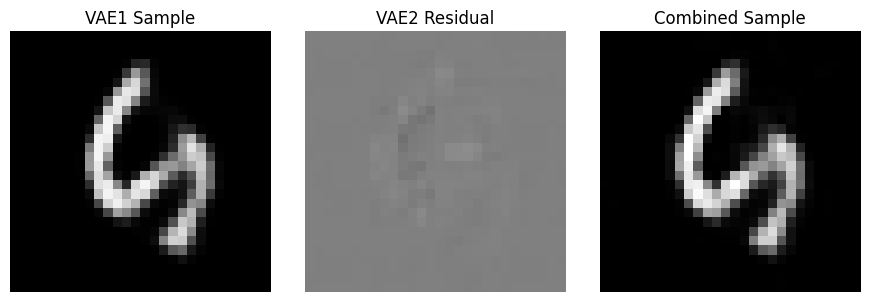

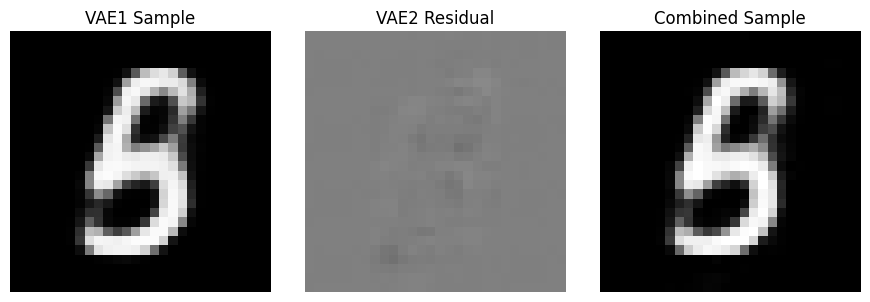

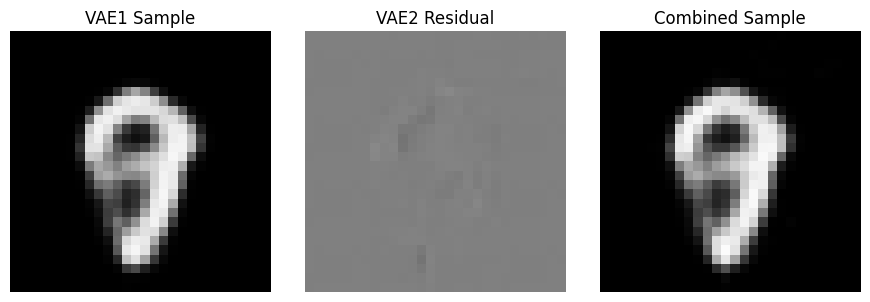

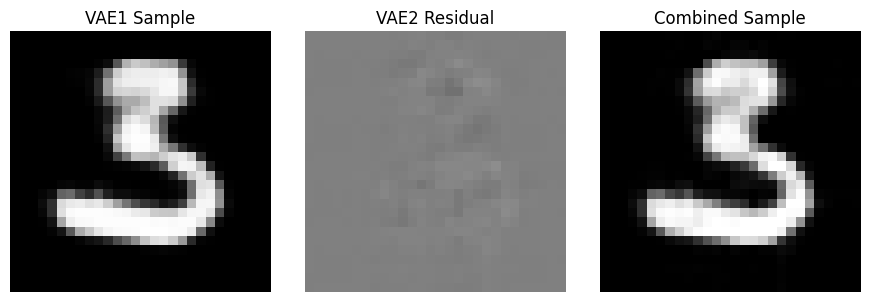

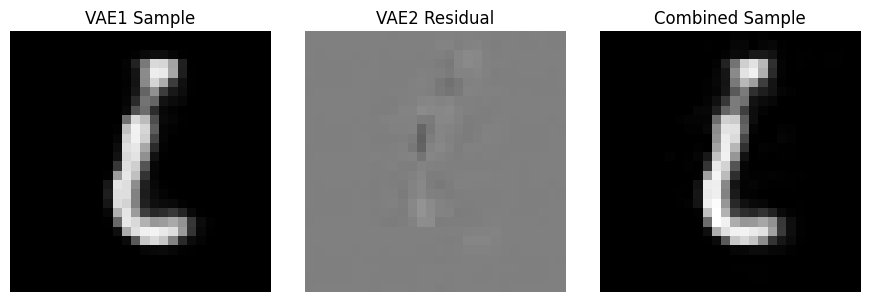

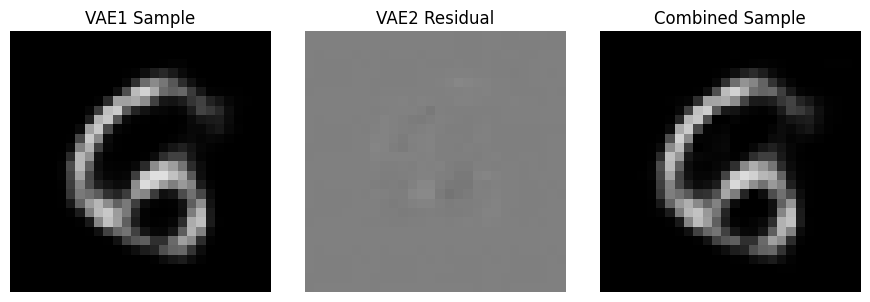

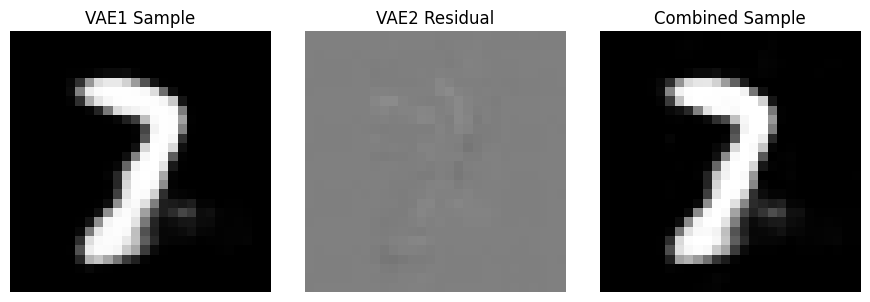

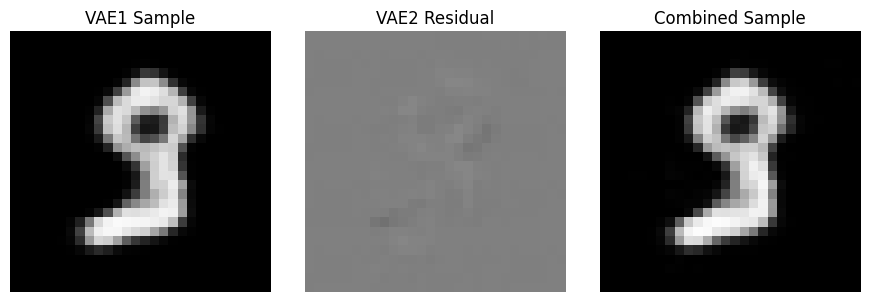

In [ ]:
def sample_and_compare(vae1, vae2, config, device, num_samples=8):
    """
    Samples from VAE1 and VAE2 pipeline and plots side-by-side:
     - VAE1-only sample
     - VAE2 residual
     - Combined VAE1+VAE2 sample
    """
    vae1.eval()
    vae2.eval()
    import matplotlib.pyplot as plt
    with torch.no_grad():
        # 1) Sample z1 and generate base samples
        z1 = torch.randn(num_samples, config['latent_dim'], device=device)
        O1 = vae1.decode(z1)  # [num_samples,1,28,28]

        # 2) Use O1 both as original and patch source to generate residuals
        residual, _, _ = vae2(O1, O1)
        O2 = torch.clamp(O1 + residual, 0, 1)

        # 3) Plot
        for i in range(num_samples):
            fig, axs = plt.subplots(1, 3, figsize=(9, 3))
            axs[0].imshow(O1[i,0].cpu(), cmap='gray',vmin=0, vmax=1)
            axs[0].set_title('VAE1 Sample')
            axs[0].axis('off')

            axs[1].imshow(residual[i,0].cpu(), cmap='gray',vmin=-1, vmax=1)
            axs[1].set_title('VAE2 Residual')
            axs[1].axis('off')

            axs[2].imshow(O2[i,0].cpu(), cmap='gray',vmin=0, vmax=1)
            axs[2].set_title('Combined Sample')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()
sample_and_compare(vae1, vae2, config, device, num_samples=8)
